In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

In [69]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic monthly demand data (Jan 2010 - Dec 2015, 72 months)
dates = pd.date_range(start='2010-01-01', end='2015-12-01', freq='M')
demand = 125 + 0.9 * np.random.normal(0, 28, len(dates)).cumsum() + np.random.normal(0, 10, len(dates))
data = pd.Series(demand, index=dates, name='Demand')

In [70]:
data

2010-01-31    152.897562
2010-02-28    133.674676
2010-03-31    166.001124
2010-04-30    162.537589
2010-05-31    191.053400
                 ...    
2015-07-31   -133.998097
2015-08-31    -97.353280
2015-09-30   -108.683868
2015-10-31   -110.357643
2015-11-30    -90.453646
Freq: ME, Name: Demand, Length: 71, dtype: float64

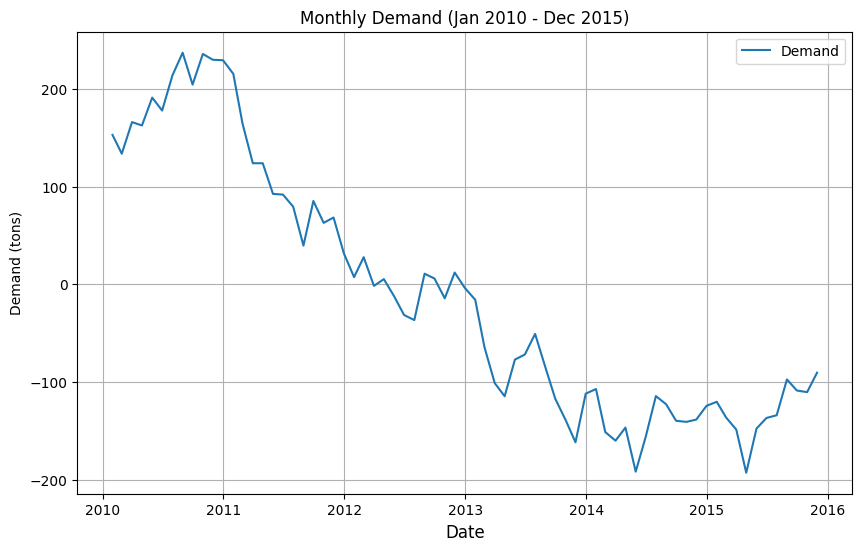

In [71]:
# Step 1: Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(data, label='Demand')
plt.title('Monthly Demand (Jan 2010 - Dec 2015)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand (tons)')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Step 2: Stationarity Test (ADF)
def adf_test(series, title=''):
    result = adfuller(x=series, maxlag=None, autolag='AIC') # ADF test
    print(f'Augmented Dickey-Fuller Test (ADF) Test for {title}:')
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print(f'Critical Values: {result[4]}')
    return result[1] < 0.05

adf_result = adf_test(data, 'Demand')
if not adf_result:
    print("Series is non-stationary; consider differencing.")
else:
    print("Series is stationary.")

Augmented Dickey-Fuller Test (ADF) Test for Demand:
ADF Statistic: -1.446
p-value: 0.560
Critical Values: {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}
Series is non-stationary; consider differencing.


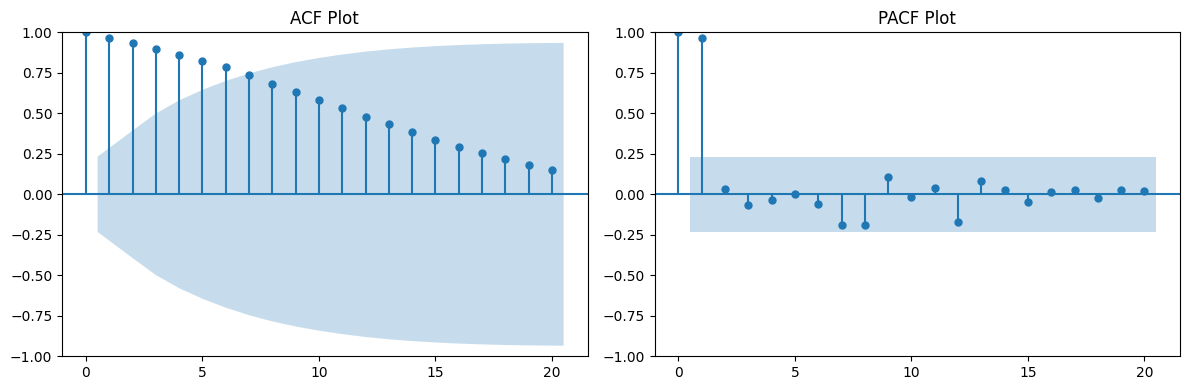

In [73]:
# Step 3: ACF and PACF Plots 
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(data, lags=20, ax=plt.gca())
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(data, lags=20, ax=plt.gca())
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

In [74]:
# Step 4: Auto-ARIMA for Model Selection
auto_model = pm.auto_arima(y=data, start_p=0, start_q=0, max_p=3, max_q=3, d=0,
                           seasonal=False, trace=True, error_action='ignore',
                           suppress_warnings=True, stepwise=True)
print(f"Auto-ARIMA suggests: {auto_model.order}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=893.192, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=673.725, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=675.615, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=675.613, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=677.613, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=675.707, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.136 seconds
Auto-ARIMA suggests: (1, 0, 0)


In [75]:
# Step 5: Fit ARIMA(1,0,1) Model (as per paper)
model = ARIMA(data, order=(1, 0, 1))
results = model.fit()

In [76]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                   71
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -334.797
Date:                Fri, 09 May 2025   AIC                            677.595
Time:                        16:43:57   BIC                            686.646
Sample:                    01-31-2010   HQIC                           681.194
                         - 11-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2950     95.662      0.139      0.889    -174.199     200.789
ar.L1          0.9800      0.023     42.453      0.000       0.935       1.025
ma.L1         -0.0410      0.130     -0.315      0.753      -0.297       0.215
sigma2       698.3386    159.995      4.365      0.000     384.755    1011.923
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.58
Prob(Q):                              0.77   Prob(JB):                         0.27
Heteroskedasticity (H):               0.91   Skew:                             0.19
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

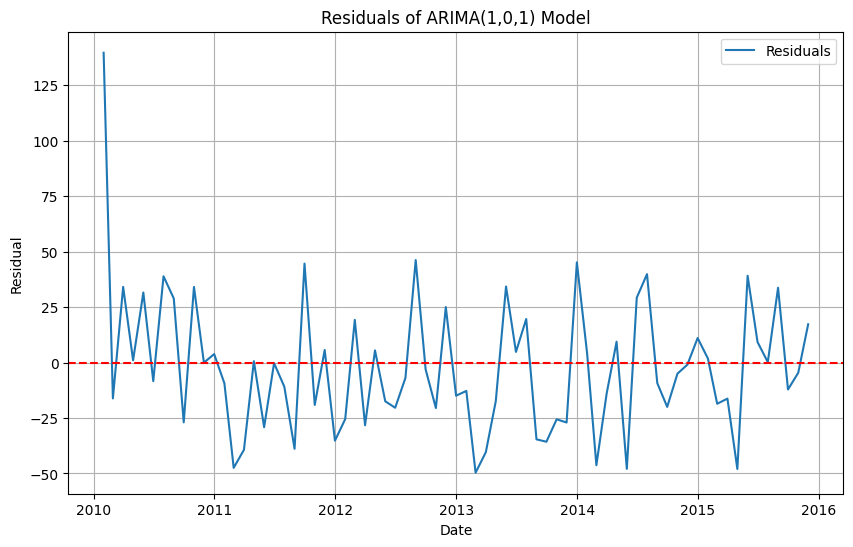

In [77]:
# Step 6: Diagnostics - Residual Analysis
residuals = results.resid

# Residual Plot
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of ARIMA(1,0,1) Model')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()

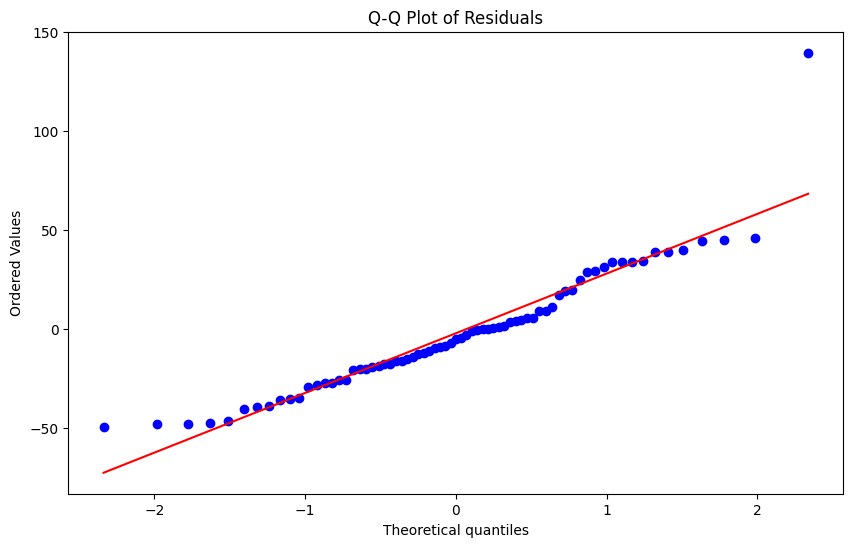

In [78]:
# Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [79]:
# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print(lb_test)


Ljung-Box Test for Residual Autocorrelation:
    lb_stat  lb_pvalue
10  5.39444   0.863321


In [80]:
# Step 7: Forecast for Jan-Oct 2016 (10 months)
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)
forecast_index = pd.date_range(start='2016-01-01', periods=forecast_steps, freq='MS')

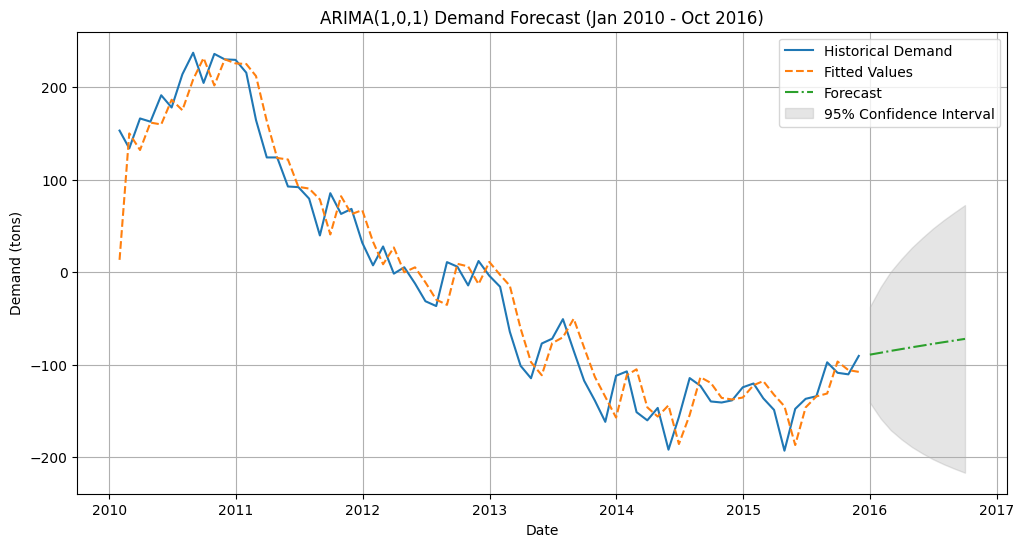

In [81]:
# Step 8: Plot Historical Data, Fitted Values, and Forecast
fitted_values = results.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Demand')
plt.plot(fitted_values, label='Fitted Values', linestyle='--')
plt.plot(forecast_index, forecast_mean, label='Forecast', linestyle='-.')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA(1,0,1) Demand Forecast (Jan 2010 - Oct 2016)')
plt.xlabel('Date')
plt.ylabel('Demand (tons)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Step 9: Save Forecast Results to CSV
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})
forecast_df.to_csv('forecast_results.csv', index=False)
print("\nForecast Results (Jan-Oct 2016):")
print(forecast_df)


Forecast Results (Jan-Oct 2016):
                 Date   Forecast    Lower_CI   Upper_CI
2015-12-31 2016-01-01 -89.086034 -140.880234 -37.291834
2016-01-31 2016-02-01 -87.038291 -158.086177 -15.990405
2016-02-29 2016-03-01 -85.031505 -170.584407   0.521396
2016-03-31 2016-04-01 -83.064858 -180.537106  14.407391
2016-04-30 2016-05-01 -81.137545 -188.822202  26.547112
2016-05-31 2016-06-01 -79.248782 -195.902794  37.405231
2016-06-30 2016-07-01 -77.397795 -202.059920  47.264329
2016-07-31 2016-08-01 -75.583831 -207.480005  56.312343
2016-08-31 2016-09-01 -73.806148 -212.294618  64.682321
2016-09-30 2016-10-01 -72.064021 -216.600944  72.472901
